### ปฏิบัติการครั้งที่ 8

ดาวน์โหลดข้อมูลอุณหภูมิสูงสุดรายวันปี 1998-2019 จาก link ข้างล่างนี้  
https://donlapark.pages.dev/229351/data/CM_temp.csv

1. เปลี่ยนจากข้อมูลรายวันให้เป็นข้อมูลค่าเฉลี่ยรายเดือน
2. จงแบ่งข้อมูลโดยให้ Test set เป็นข้อมูลของ 24 เดือนสุดท้ายและ Training set เป็นข้อมูลก่อนหน้าทั้งหมด
3. ลองสร้างโมเดล Holt-Winters แบบต่างๆ (damped, non-damped, additive, multiplicative etc.) แล้วระบุโมเดลที่ดีที่ให้ค่า RMSE บน test set น้อยที่สุด
4. จงแสดงแผนภาพของข้อมูลจริงกับข้อมูลที่ได้ในข้อ 3

In [ ]:
!wget -O CM_temp.csv https://donlapark.pages.dev/229351/data/CM_temp.csv

--2024-02-08 04:36:47--  https://donlapark.pages.dev/229351/data/CM_temp.csv
Resolving donlapark.pages.dev (donlapark.pages.dev)... 172.66.44.200, 172.66.47.56, 2606:4700:310c::ac42:2f38, ...
Connecting to donlapark.pages.dev (donlapark.pages.dev)|172.66.44.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139473 (136K) [text/csv]
Saving to: ‘CM_temp.csv’

CM_temp.csv         100%[===================>] 136.20K  --.-KB/s    in 0.02s   

2024-02-08 04:36:47 (6.16 MB/s) - ‘CM_temp.csv’ saved [139473/139473]



In [ ]:
# import module ที่ต้องใช้
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from datetime import datetime

In [ ]:
# ฟังก์ชันที่เปลี่ยน string ให้เป็น datetime
def parser(dates):
  return datetime.strptime(dates, '%Y-%m-%d')

# parse_dates ชื่อของคอลัมน์ที่จะเปลี่ยนให้เป็น datetime
# index_col ชื่อของคอลัมน์ที่จะให้เป็น index
# date_parser ฟังก์ชันที่เปลี่ยน string ให้เป็น datetime
data = pd.read_csv('CM_temp.csv', parse_dates=['Date'],
                                        index_col='Date',
                                        date_parser=parser)

data.tail()

,MaxTemp
Date,
2019-07-27,26.2
2019-07-28,34.2
2019-07-29,34.4
2019-07-30,33.5
2019-07-31,30.7


<Axes: xlabel='Date'>

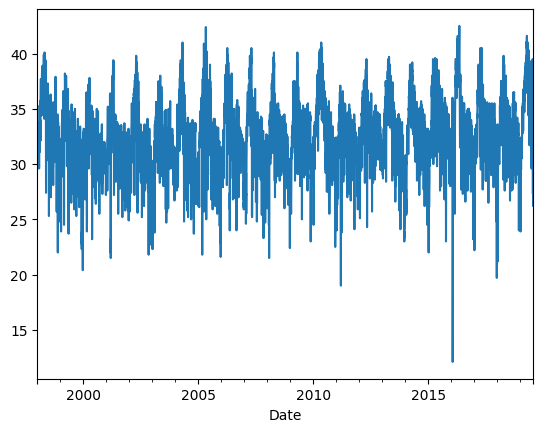

In [ ]:
data['MaxTemp'].plot() # ข้อมูลของกรมอุตุฯ

### 1. เปลี่ยนจากข้อมูลรายวันให้เป็นข้อมูลค่าเฉลี่ยรายเดือน

ข้อมูลที่ได้เป็นข้อมูลรายวัน ทำการหาค่าเฉลี่ยรายเดือนด้วย method `resample`

In [12]:
data_monthly = data['MaxTemp'].resample("M").mean()

data_monthly.head()

Date
1998-01-31    31.687097
1998-02-28    33.685714
1998-03-31    37.103226
1998-04-30    37.910000
1998-05-31    35.848387
Freq: M, Name: MaxTemp, dtype: float64

<Axes: xlabel='Date'>

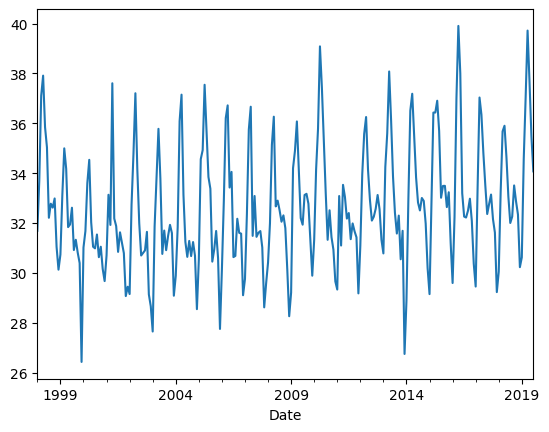

In [13]:
data_monthly.plot()

In [14]:
def rmse(y_true,y_pred):
  # Inputs
  # y_true: actual value, y_pred: predicted values
  # Output: RMSE between y_true and y_pred
  return np.sqrt(np.mean(np.square(y_true-y_pred)))

### 2. จงแบ่งข้อมูลโดยให้ Test set เป็นข้อมูลของ 24 เดือนสุดท้ายและ Training set เป็นข้อมูลก่อนหน้าทั้งหมด

In [16]:
data

,MaxTemp
Date,
1998-01-01,30.6
1998-01-02,32.0
1998-01-03,31.6
1998-01-04,32.1
1998-01-05,31.2
...,...
2019-07-27,26.2
2019-07-28,34.2
2019-07-29,34.4


In [23]:
train = data_monthly[:-24]
test = data_monthly[-24:]

print(train)
print("-----------------------")
print(test)

Date
1998-01-31    31.687097
1998-02-28    33.685714
1998-03-31    37.103226
1998-04-30    37.910000
1998-05-31    35.848387
                ...    
2017-03-31    37.032258
2017-04-30    36.340000
2017-05-31    34.806452
2017-06-30    33.523333
2017-07-31    32.361290
Freq: M, Name: MaxTemp, Length: 235, dtype: float64
-----------------------
Date
2017-08-31    32.764516
2017-09-30    33.140000
2017-10-31    32.158065
2017-11-30    31.616667
2017-12-31    29.229032
2018-01-31    30.048387
2018-02-28    33.253571
2018-03-31    35.674194
2018-04-30    35.900000
2018-05-31    34.648387
2018-06-30    33.066667
2018-07-31    32.000000
2018-08-31    32.258065
2018-09-30    33.506667
2018-10-31    32.864516
2018-11-30    32.336667
2018-12-31    30.229032
2019-01-31    30.622581
2019-02-28    34.564286
2019-03-31    37.051613
2019-04-30    39.716667
2019-05-31    37.680645
2019-06-30    35.466667
2019-07-31    34.070968
Freq: M, Name: MaxTemp, dtype: float64


### 3. ลองสร้างโมเดล Holt-Winters แบบต่างๆ (damped, non-damped, additive, multiplicative etc.) แล้วระบุโมเดลที่ดีที่ให้ค่า RMSE บน test set น้อยที่สุด

#### ทดสอบ model แบบ None ทั้งหมด

In [72]:
es = ExponentialSmoothing(train,
                          trend = None,
                          damped_trend=False,
                          seasonal=None,
                          seasonal_periods=12)
es_fit = es.fit(optimized=True)
yhat = es_fit.predict('2017-08-31', '2019-07-31')

print('RMSE:',rmse(test,yhat))

RMSE: 2.7206000809500575


#### ทดสอบ model กับ trend additive

In [74]:
es = ExponentialSmoothing(train,
                          trend = 'add',
                          damped_trend=False,
                          seasonal=None,
                          seasonal_periods=12)
es_fit = es.fit(optimized=True)
yhat = es_fit.predict('2017-08-31', '2019-07-31')

print('RMSE:',rmse(test,yhat))

RMSE: 2.6972653182360595


In [77]:
es = ExponentialSmoothing(train,
                          trend = 'add',
                          damped_trend=True,
                          seasonal=None,
                          seasonal_periods=12)
es_fit = es.fit(optimized=True)
yhat = es_fit.predict('2017-08-31', '2019-07-31')

print('RMSE:',rmse(test,yhat))

RMSE: 2.7206000811236914


#### ทดสอบ model กับ trend multiplicative

In [76]:
es = ExponentialSmoothing(train,
                          trend = 'mul',
                          damped_trend=False,
                          seasonal=None,
                          seasonal_periods=12)
es_fit = es.fit(optimized=True)
yhat = es_fit.predict('2017-08-31', '2019-07-31')

print('RMSE:',rmse(test,yhat))

RMSE: 3.2471794931736815


In [78]:
es = ExponentialSmoothing(train,
                          trend = 'mul',
                          damped_trend=True,
                          seasonal=None,
                          seasonal_periods=12)
es_fit = es.fit(optimized=True)
yhat = es_fit.predict('2017-08-31', '2019-07-31')

print('RMSE:',rmse(test,yhat))

RMSE: 2.5478954102668396


#### ทดสอบ model กับ seasonal additive

In [80]:
es = ExponentialSmoothing(train,
                          trend = None,
                          damped_trend=False,
                          seasonal='add',
                          seasonal_periods=12)
es_fit = es.fit(optimized=True)
yhat = es_fit.predict('2017-08-31', '2019-07-31')

print('RMSE:',rmse(test,yhat))

RMSE: 1.1242862320616602


In [82]:
es = ExponentialSmoothing(train,
                          trend = 'add',
                          damped_trend=False,
                          seasonal='add',
                          seasonal_periods=12)
es_fit = es.fit(optimized=True)
yhat = es_fit.predict('2017-08-31', '2019-07-31')

print('RMSE:',rmse(test,yhat))

RMSE: 1.166940941237247


In [83]:
es = ExponentialSmoothing(train,
                          trend = 'add',
                          damped_trend=True,
                          seasonal='add',
                          seasonal_periods=12)
es_fit = es.fit(optimized=True)
yhat = es_fit.predict('2017-08-31', '2019-07-31')

print('RMSE:',rmse(test,yhat))

RMSE: 1.113500495732834


In [84]:
es = ExponentialSmoothing(train,
                          trend = 'mul',
                          damped_trend=False,
                          seasonal='add',
                          seasonal_periods=12)
es_fit = es.fit(optimized=True)
yhat = es_fit.predict('2017-08-31', '2019-07-31')

print('RMSE:',rmse(test,yhat))

RMSE: 1.187257634293564


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


In [85]:
es = ExponentialSmoothing(train,
                          trend = 'mul',
                          damped_trend=True,
                          seasonal='add',
                          seasonal_periods=12)
es_fit = es.fit(optimized=True)
yhat = es_fit.predict('2017-08-31', '2019-07-31')

print('RMSE:',rmse(test,yhat))

RMSE: nan


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:1365: RuntimeWarning: invalid value encountered in power
  + (alphac * trended(lvls[i - 1], dampen(b[i - 1], phi)))
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:1369: RuntimeWarning: invalid value encountered in power
  betac * dampen(b[i - 1], phi)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:1373: RuntimeWarning: invalid value encountered in power
  - (gamma * trended(lvls[i - 1], dampen(b[i - 1], phi)))
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:1380: RuntimeWarning: invalid value encountered in p

#### ทดสอบ model กับ seasonal multiplicative

In [89]:
es = ExponentialSmoothing(train,
                          trend = None,
                          damped_trend=False,
                          seasonal='mul',
                          seasonal_periods=12)
es_fit = es.fit(optimized=True)
yhat = es_fit.predict('2017-08-31', '2019-07-31')

print('RMSE:',rmse(test,yhat))

RMSE: 1.1200378264718367


In [92]:
es = ExponentialSmoothing(train,
                          trend = 'add',
                          damped_trend=False,
                          seasonal='mul',
                          seasonal_periods=12)
es_fit = es.fit(optimized=True)
yhat = es_fit.predict('2017-08-31', '2019-07-31')

print('RMSE:',rmse(test,yhat))

RMSE: 1.164096447004152


In [93]:
es = ExponentialSmoothing(train,
                          trend = 'add',
                          damped_trend=True,
                          seasonal='mul',
                          seasonal_periods=12)
es_fit = es.fit(optimized=True)
yhat = es_fit.predict('2017-08-31', '2019-07-31')

print('RMSE:',rmse(test,yhat))

RMSE: 1.106246273497451


In [94]:
es = ExponentialSmoothing(train,
                          trend = 'mul',
                          damped_trend=False,
                          seasonal='mul',
                          seasonal_periods=12)
es_fit = es.fit(optimized=True)
yhat = es_fit.predict('2017-08-31', '2019-07-31')

print('RMSE:',rmse(test,yhat))

RMSE: 1.1824921945168116


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


In [71]:
es = ExponentialSmoothing(train,
                          trend = 'mul',
                          damped_trend=True,
                          seasonal='mul',
                          seasonal_periods=12)
es_fit = es.fit(optimized=True)
yhat = es_fit.predict('2017-08-31', '2019-07-31')

print('RMSE:',rmse(test,yhat))

RMSE: 1.106433939428429


#### โมเดลที่ดีที่ให้ค่า RMSE บน test set น้อยที่สุด
คือ model ที่มีเป็นแบบ additive trend, damped, multiplicative seasonality
โดยมีค่า RMSE เป็น 1.106246273497451 ซึ่งเป็นโมเดลเดียวที่มีค่า RMSE น้อยที่สุด

In [97]:
es = ExponentialSmoothing(train,
                          trend = 'add',
                          damped_trend=True,
                          seasonal='mul',
                          seasonal_periods=12)
es_fit = es.fit(optimized=True)
yhat = es_fit.predict('2017-08-31', '2019-07-31')

print('RMSE:',rmse(test,yhat))

RMSE: 1.106246273497451


### 4. จงแสดงแผนภาพของข้อมูลจริงกับข้อมูลที่ได้ในข้อ 3

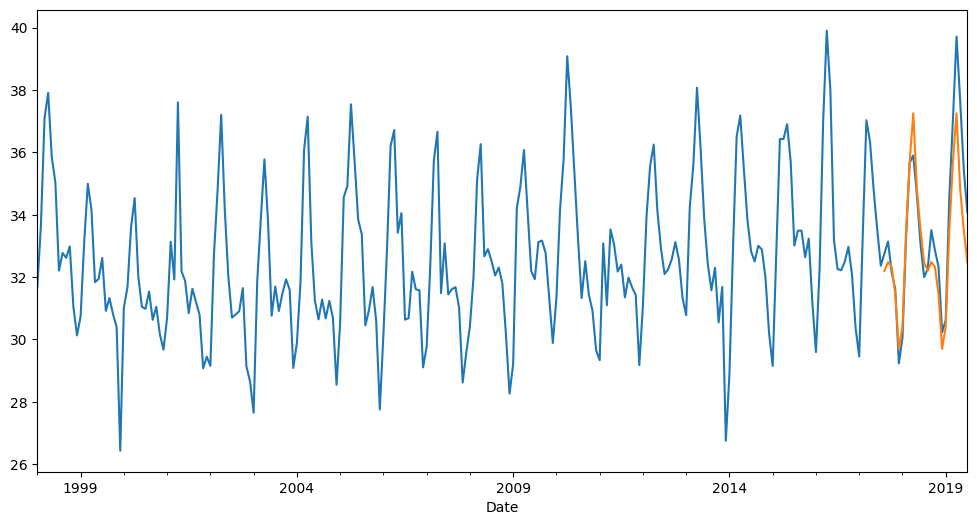

In [98]:
plt.figure(figsize=(12,6))
data_monthly.plot() # ข้อมูลจริง
yhat.plot(); # ข้อมูลที่ทำนายได้